### RoBERTa Model

In [1]:
pip install transformers datasets torch scikit-learn pandas tqdm


In [2]:
import pandas as pd

In [3]:
from google.colab import drive


In [4]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Amazon Fine Food Reviews dataset. It has 568454 rows and 10 columns

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SentimentAnalysis/Reviews.csv")
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.shape

(568454, 10)

### Preprocessing

In [7]:
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


Columns : summary and ProfileName have NaN values. Drop rows with NaN values

In [8]:
# Drop NaN values (if any)
df.dropna(inplace=True)


In [9]:
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,0
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,0
Text,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568401 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568401 non-null  int64 
 1   ProductId               568401 non-null  object
 2   UserId                  568401 non-null  object
 3   ProfileName             568401 non-null  object
 4   HelpfulnessNumerator    568401 non-null  int64 
 5   HelpfulnessDenominator  568401 non-null  int64 
 6   Score                   568401 non-null  int64 
 7   Time                    568401 non-null  int64 
 8   Summary                 568401 non-null  object
 9   Text                    568401 non-null  object
dtypes: int64(5), object(5)
memory usage: 47.7+ MB


In [11]:
invalid_score = df[(df["Score"] < 1) | (df["Score"] > 5)]
invalid_score

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


Check Time is from Oct 1999 - Oct 2012:
- October 1, 1999 at 00:00:00 UTC → 938736000
- November 1, 2012 at 00:00:00 UTC → 1351728000

In [12]:
invalid_date = df[(df["Time"] < 938736000) | (df["Time"] > 1351728000)]
print(invalid_date)

Empty DataFrame
Columns: [Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text]
Index: []


In [13]:
df.shape

(568401, 10)

In [14]:
#### Randomly selecting 50000 reviews from Amazon Fine Food Reviews dataset(df)

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Convert Score to binary sentiment labels (positive/negative)
df['Sentiment_label'] = df['Score'].apply(lambda x: 'positive' if x >= 4 else 'negative')

#Create `Combined_Text` column
df["Combined_Text"] = df["Summary"].fillna('') + " " + df["Text"].fillna('')

test_size = 0.2  # 20% test set

#Stratify train-test split based on `Sentiment_label`
train_df, test_df = train_test_split(df, test_size=test_size, stratify=df["Sentiment_label"], random_state=42)

# Sample exactly 12,500 reviews for `test_df`
test_df = test_df.groupby("Sentiment_label", group_keys=False).apply(lambda x: x.sample(n=int(12500 * len(x) / len(test_df)), random_state=42))

#Ensure `test_df` includes `Combined_Text`
test_df["Combined_Text"] = test_df["Summary"].fillna('') + " " + test_df["Text"].fillna('')

# Oversample training set for balanced classes
train_pos_oversampled = resample(train_df[train_df["Sentiment_label"] == 'positive'],
                                 replace=True, n_samples=25000, random_state=42)
train_neg_oversampled = resample(train_df[train_df["Sentiment_label"] == 'negative'],
                                 replace=True, n_samples=25000, random_state=42)

#Create final balanced training dataset
train_oversampled_df = pd.concat([train_pos_oversampled, train_neg_oversampled], ignore_index=True)

#Ensure `train_oversampled_df` includes `Combined_Text`
train_oversampled_df["Combined_Text"] = train_oversampled_df["Summary"].fillna('') + " " + train_oversampled_df["Text"].fillna('')

#Shuffle the training dataset
train_oversampled_df = train_oversampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

#Check the final class distribution
print("Train Set Distribution (After Oversampling):\n", train_oversampled_df["Sentiment_label"].value_counts())
print("\nTest Set Distribution:\n", test_df["Sentiment_label"].value_counts())


<ipython-input-15-55328b53101f>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby("Sentiment_label", group_keys=False).apply(lambda x: x.sample(n=int(12500 * len(x) / len(test_df)), random_state=42))


Train Set Distribution (After Oversampling):
 Sentiment_label
negative    25000
positive    25000
Name: count, dtype: int64

Test Set Distribution:
 Sentiment_label
positive    9758
negative    2741
Name: count, dtype: int64


In [16]:
test_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_label,Combined_Text
117891,117892,B000X1Q1G8,A2ZL7OS8XCB6U8,bloomies01,1,1,1,1311811200,Get real peanut butter,"I dont know why, but I had a feeling this woul...",negative,"Get real peanut butter I dont know why, but I ..."
18154,18155,B008ZRKZSM,A3BMY42WTQRSMQ,hello,2,8,2,1300665600,Yuck!,This tasted so odd. All I can say is it tasted...,negative,Yuck! This tasted so odd. All I can say is it ...
127478,127479,B005VOONKI,A3SLC8F6VIWXIR,"John T. Horner ""jthorner""",0,2,2,1335052800,"Weak, uninspiring coffee is the result I got","The idea of these ""coffee bags"" is neat. Put t...",negative,"Weak, uninspiring coffee is the result I got T..."
400752,400753,B000ES1R2I,A3GF0GES2U2V19,Betty Thoma,0,1,2,1241568000,Really disappointing,This tea was a real disappointment. I really ...,negative,Really disappointing This tea was a real disap...
331435,331436,B000EVT08S,A1437CZ7DZQK7L,"K. Forttrell ""soccer monster""",2,3,3,1319673600,No Techno Color for my Bears :(,When the item arrived the bears were just regu...,negative,No Techno Color for my Bears :( When the item ...


In [17]:
#pip install transformers pandas torch tqdm


In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load RoBERTa tokenizer & model
MODEL_NAME = "siebert/sentiment-roberta-large-english"  # Pretrained RoBERTa model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load RoBERTa model for binary classification (2 output labels)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [19]:
test_df["Sentiment_label"].isnull().sum()

0

In [20]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# convert test set reviews into a list
test_texts = test_df["Combined_Text"].tolist()

# Tokenize dataset in chunks
batch_size = 32  # Adjust to fit GPU memory (try 16 if still OOM)
encoded_test = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

# Create DataLoader for batch processing
dataset = TensorDataset(encoded_test["input_ids"], encoded_test["attention_mask"])
dataloader = DataLoader(dataset, batch_size=batch_size)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store predictions
all_preds = []

# Process batches to avoid memory overload
with torch.no_grad():
    for batch in dataloader:
        torch.cuda.empty_cache()  # Free unused memory
        batch = [t.to(device) for t in batch]  # Move batch to GPU
        inputs = {"input_ids": batch[0], "attention_mask": batch[1]}
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Move back to CPU
        all_preds.extend(preds)

# Map numerical predictions back to sentiment labels
sentiment_map = {0: "negative", 1: "positive"}
test_df["Predicted_Sentiment"] = [sentiment_map[label] for label in all_preds]

# Convert labels to numerical values for evaluation
test_df["Sentiment_label"] = test_df["Sentiment_label"].map({"negative": 0, "positive": 1})
test_df["Predicted_Sentiment"] = test_df["Predicted_Sentiment"].map({"negative": 0, "positive": 1})

#Compute accuracy
accuracy = accuracy_score(test_df["Sentiment_label"], test_df["Predicted_Sentiment"])
print(f"Model Accuracy on Test Set: {accuracy:.2%}")

precision = precision_score(test_df["Sentiment_label"], test_df["Predicted_Sentiment"])
print(f"Model Precision on Test Set: {precision:.2%}")

recall = recall_score(test_df["Sentiment_label"], test_df["Predicted_Sentiment"])
print(f"Model Recall on Test Set: {recall:.2%}")

f1 = 2 * (precision * recall) / (precision + recall)
print(f"Model F1 Score on Test Set: {f1:.2%}")

#Print classification report
print(classification_report(test_df["Sentiment_label"], test_df["Predicted_Sentiment"], target_names=["Negative", "Positive"]))


Model Accuracy on Test Set: 94.91%
Model Precision on Test Set: 95.99%
Model Recall on Test Set: 97.56%
Model F1 Score on Test Set: 96.77%
              precision    recall  f1-score   support

    Negative       0.91      0.85      0.88      2741
    Positive       0.96      0.98      0.97      9758

    accuracy                           0.95     12499
   macro avg       0.93      0.92      0.92     12499
weighted avg       0.95      0.95      0.95     12499



In [21]:
def predict_sentiment(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move to GPU if available

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probs).item()

    # Map labels (0 = Negative, 1 = Positive)
    sentiment_map = {0: "negative", 1: "positive"}

    return sentiment_map[predicted_class], probs.tolist()

# Example reviews
sample_reviews = [
    "The product was amazing! I loved it.",
    "It was okay, nothing special but not bad either.",
    "This is the worst thing I have ever bought!",
    "As an avid chess enthusiast, I've always sought a set that marries classic aesthetics with modern convenience. The Hurdaos Magnetic Wooden Chess Set has exceeded my expectations in every way. The 15-inch handcrafted board is not only visually stunning but also folds into a compact, portable case, making it ideal for both home and travel. The magnetic pieces stay firmly in place during play, yet are easy to move, ensuring an uninterrupted game even on the go. Each piece is meticulously crafted, adding a touch of elegance to every match. Whether you're a seasoned player or a beginner, this set offers a seamless blend of functionality and style. Highly recommended",
    "They are all dry. Only 9 markers worked out of 36 markers it has in the box. You are better off just getting the brand Expo."
]

# Predict for each review
for review in sample_reviews:
    sentiment, probabilities = predict_sentiment(review)
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\nProbabilities: {probabilities}\n")


Review: The product was amazing! I loved it.
Predicted Sentiment: positive
Probabilities: [[0.0010908329859375954, 0.9989091157913208]]

Review: It was okay, nothing special but not bad either.
Predicted Sentiment: negative
Probabilities: [[0.9976049661636353, 0.002395060146227479]]

Review: This is the worst thing I have ever bought!
Predicted Sentiment: negative
Probabilities: [[0.9995032548904419, 0.0004967328859493136]]

Review: As an avid chess enthusiast, I've always sought a set that marries classic aesthetics with modern convenience. The Hurdaos Magnetic Wooden Chess Set has exceeded my expectations in every way. The 15-inch handcrafted board is not only visually stunning but also folds into a compact, portable case, making it ideal for both home and travel. The magnetic pieces stay firmly in place during play, yet are easy to move, ensuring an uninterrupted game even on the go. Each piece is meticulously crafted, adding a touch of elegance to every match. Whether you're a seas

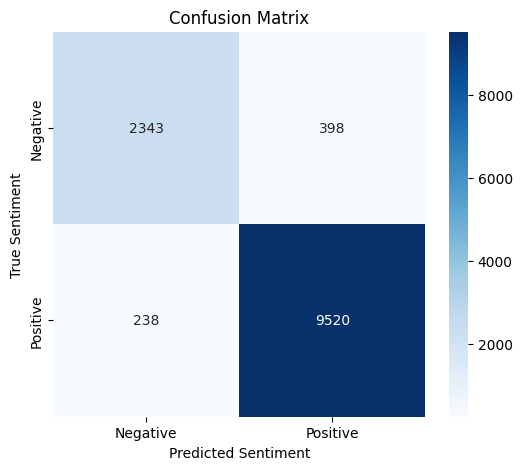

In [22]:
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df["Sentiment_label"], test_df["Predicted_Sentiment"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])

plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.title("Confusion Matrix")
plt.show()

